In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [3]:
base_dir = '/home/cyp/Documents/Dataset/cat_dog_small/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [11]:
from glob import glob

def clean_directory(dir_path, ext=".jpg"):
    files = glob(os.path.join(dir_path, ".*" + ext))  # this line find all files witch starts with . and ends with given extension
    for file_path in files:
        os.remove(file_path)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                directory,
                target_size = (150, 150),
                batch_size = batch_size,
                class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i* batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels 

clean_directory(test_dir, ext = '.jpg')

train_features, train_labels = extract_features(train_dir, 2000)
val_features, validation_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(val_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
val_features = np.reshape(val_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 447us/step - loss: 0.5958 - acc: 0.6805 - val_loss: 0.4320 - val_acc: 0.8340
Epoch 2/30
2000/2000 [==============================] - 1s 336us/step - loss: 0.4354 - acc: 0.8015 - val_loss: 0.3609 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 1s 345us/step - loss: 0.3529 - acc: 0.8595 - val_loss: 0.3324 - val_acc: 0.8510
Epoch 4/30
2000/2000 [==============================] - 1s 352us/step - loss: 0.3206 - acc: 0.8770 - val_loss: 0.2978 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 1s 337us/step - loss: 0.2977 - acc: 0.8785 - val_loss: 0.2903 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 1s 329us/step - loss: 0.2624 - acc: 0.8965 - val_loss: 0.2737 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 1s 317us/step - loss: 0.2545 - acc: 0.8960 - val_loss: 0.2664 - val_acc: 0.8970


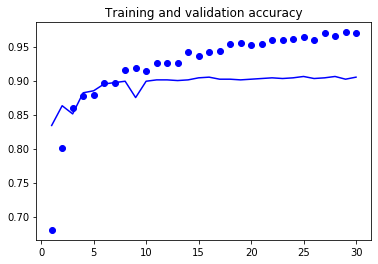

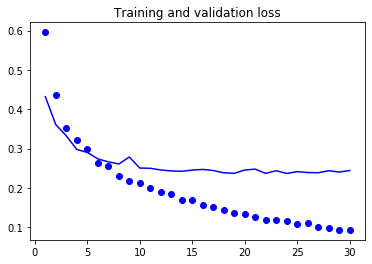

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.show()

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
conv_base.trainable = False

In [25]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size=20,
                  class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
                        val_dir,
                        target_size=(150, 150),
                        batch_size=20,
                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
                train_generator,
                steps_per_epoch=100,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 11s 112ms/step - loss: 0.5802 - acc: 0.6955 - val_loss: 0.4797 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 10s 100ms/step - loss: 0.4778 - acc: 0.7890 - val_loss: 0.4851 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 10s 100ms/step - loss: 0.4257 - acc: 0.8065 - val_loss: 0.3435 - val_acc: 0.8590
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3965 - acc: 0.8215 - val_loss: 0.2341 - val_acc: 0.8630
Epoch 5/30
100/100 [==============================] - 10s 100ms/step - loss: 0.3829 - acc: 0.8320 - val_loss: 0.3385 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3695 - acc: 0.8415 - val_loss: 0.3357 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3586 - acc: 0.8505 - val_lo

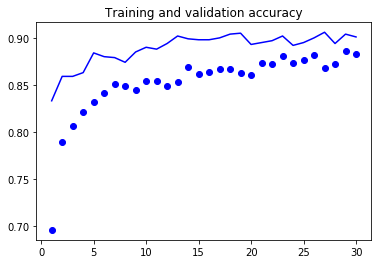

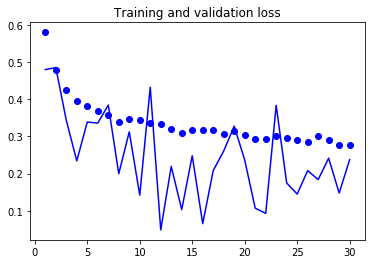

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.show()